In [159]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

df = pd.read_csv("bars.csv", parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)
fee = 0.001
leverage = 2.5
# df = df.loc['2025-07-01 00:00:00':'2025-07-25 00:00:00']

In [160]:
low_seq = (
    # (df['low'].shift(5) > df['low'].shift(4)) &
    (df['low'].shift(4) > df['low'].shift(3)) &
    (df['low'].shift(3) > df['low'].shift(2)) &
    (df['low'].shift(2) > df['low'].shift(1))
)

close_seq = (
    # (df['close'].shift(5) > df['close'].shift(4)) &
    (df['close'].shift(4) > df['close'].shift(3)) &
    (df['close'].shift(3) > df['close'].shift(2)) &
    (df['close'].shift(2) > df['close'].shift(1))
)

1.9535474984036585


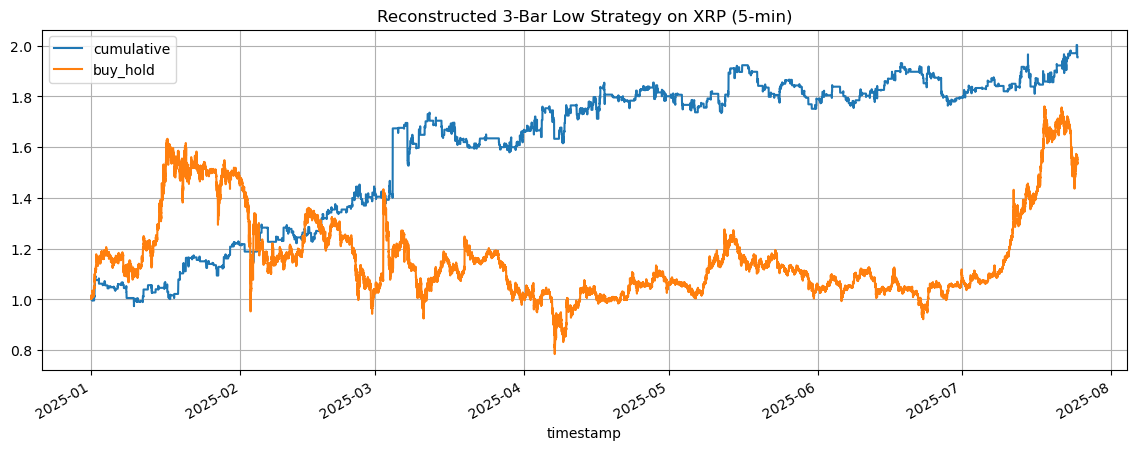

In [161]:
breakout = df['close'] > df['high'].shift(1)
df['entry_signal'] = low_seq & close_seq & breakout

df['position'] = 0
entry_indices = df.index[df['entry_signal']]
in_position = False  # flag to avoid overlapping trades

for i in entry_indices:
    idx = df.index.get_loc(i)
    if idx + 1 >= len(df): continue

    if in_position:
        continue  # skip if already in a trade

    entry_price = df.iloc[idx]['close']
    df.at[df.index[idx + 1], 'position'] = 1*leverage
    in_position = True

    for j in range(1, 5):  # hold max 4 bars
        if idx + 1 + j >= len(df): break

        exit_price = df.iloc[idx + 1 + j]['close']
        ret = ((exit_price - entry_price) / entry_price) - 2*fee

        if ret >= 0.015 or ret <= -0.008:
            # exit trade - set position to 0 for remaining bars
            for k in range(j + 1, 5):  # clear future positions
                if idx + 1 + k >= len(df): break
                df.at[df.index[idx + 1 + k], 'position'] = 0
            in_position = False
            break
        else:
            df.at[df.index[idx + 1 + j], 'position'] = 1*leverage

    in_position = False  # auto-exit after holding 4 bars
df['return'] = df['close'].pct_change()
df['strategy_return'] = df['position'].shift(1) * df['return']
df['cumulative'] = (1 + df['strategy_return']).cumprod()
df['buy_hold'] = (1 + df['return']).cumprod()

df[['cumulative', 'buy_hold']].plot(figsize=(14, 5))
plt.title("Reconstructed 3-Bar Low Strategy on XRP (5-min)")
plt.grid(True)
print(df['cumulative'][-1])
plt.show()

### loop

In [462]:
results = []
breakout = df['close'] > df['high'].shift(1)
entry_signal = low_seq & close_seq & breakout

tp_range = np.arange(0.0045, 0.0161, 0.0005)
sl_range = np.arange(-0.0065, -0.0126, -0.001)
j_range = range(2, 5)

for j in tqdm(j_range, desc='Holding periods'):
    for tp in tp_range:
        for sl in sl_range:
            df_copy = df.copy()
            df_copy['entry_signal'] = entry_signal
            df_copy['position'] = 0
            entry_indices = df_copy.index[df_copy['entry_signal']]

            for i in entry_indices:
                idx = df_copy.index.get_loc(i)
                if idx + 1 >= len(df_copy): continue

                entry_price = df_copy.iloc[idx + 1]['open']
                for k in range(1, j + 1):
                    if idx + 1 + k >= len(df_copy): break
                    exit_price = df_copy.iloc[idx + 1 + k]['close']
                    ret = (exit_price - entry_price) / entry_price

                    if ret >= tp or ret <= sl:
                        df_copy.at[df_copy.index[idx + 1 + k], 'position'] = 0
                        break
                    else:
                        df_copy.at[df_copy.index[idx + 1 + k], 'position'] = 1

            df_copy['return'] = df_copy['close'].pct_change()
            df_copy['strategy_return'] = df_copy['position'].shift(1) * df_copy['return']
            df_copy['cumulative'] = (1 + df_copy['strategy_return']).cumprod()
            final_cum = df_copy['cumulative'].iloc[-1]

            results.append({
                'j': j,
                'tp': round(tp, 5),
                'sl': round(sl, 5),
                'final_cumulative': final_cum
            })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by best performance
results_df = results_df.sort_values(by='final_cumulative', ascending=False)


Holding periods: 100%|██████████| 3/3 [02:36<00:00, 52.30s/it]


In [463]:
results_df.head(20)

,j,tp,sl,final_cumulative
455,4,0.0130,-0.0065,1.036837
461,4,0.0130,-0.0125,1.036359
459,4,0.0130,-0.0105,1.033707
448,4,0.0125,-0.0065,1.033463
476,4,0.0145,-0.0065,1.033296
462,4,0.0135,-0.0065,1.033296
483,4,0.0150,-0.0065,1.033296
469,4,0.0140,-0.0065,1.033296
490,4,0.0155,-0.0065,1.033296
454,4,0.0125,-0.0125,1.032986


In [403]:
results_df.to_csv('results_df.csv')

### short

Final cumulative return: 1.2931


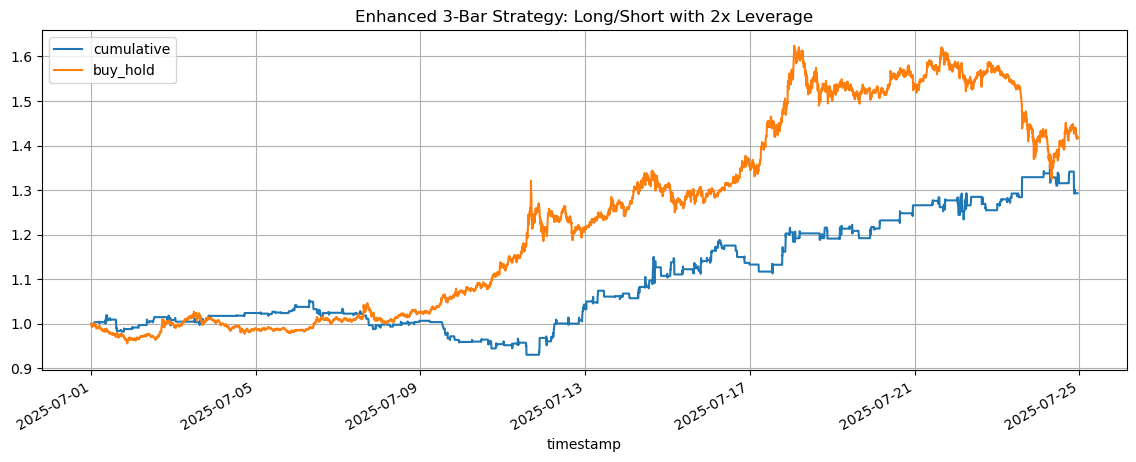

In [ ]:
long_breakout = df['close'] > df['high'].shift(1)
df['long_entry_signal'] = low_seq & close_seq & long_breakout

# Short signals (inverse logic)
high_seq = (
    (df['high'].shift(3) < df['high'].shift(2)) &
    (df['high'].shift(2) < df['high'].shift(1))
)

close_seq_short = (
    (df['close'].shift(3) < df['close'].shift(2)) &
    (df['close'].shift(2) < df['close'].shift(1))
)

short_breakdown = df['close'] < df['low'].shift(1)
df['short_entry_signal'] = high_seq & close_seq_short & short_breakdown

df['position'] = 0
long_indices = df.index[df['long_entry_signal']]
short_indices = df.index[df['short_entry_signal']]

# Combine and sort all signals
all_signals = []
for i in long_indices:
    all_signals.append((i, 'long'))
for i in short_indices:
    all_signals.append((i, 'short'))

all_signals.sort(key=lambda x: x[0])  # Sort by timestamp

in_position = False

for signal_time, signal_type in all_signals:
    idx = df.index.get_loc(signal_time)
    if idx + 1 >= len(df): continue

    if in_position:
        continue  # skip if already in a trade

    entry_price = df.iloc[idx]['close']
    
    # Set position: +2 for long, -2 for short (2x leverage)
    position_size = 2 if signal_type == 'long' else -2
    df.at[df.index[idx + 1], 'position'] = position_size
    in_position = True

    for j in range(1, 5):  # hold max 4 bars
        if idx + 1 + j >= len(df): break

        exit_price = df.iloc[idx + 1 + j]['close']
        
        # Calculate return based on position direction
        if signal_type == 'long':
            ret = ((exit_price - entry_price) / entry_price) - 2*fee
        else:  # short
            ret = ((entry_price - exit_price) / entry_price) - 2*fee

        # Exit conditions (same for both long and short)
        if ret >= 0.015 or ret <= -0.008:
            # exit trade - set position to 0 for remaining bars
            for k in range(j + 1, 5):
                if idx + 1 + k >= len(df): break
                df.at[df.index[idx + 1 + k], 'position'] = 0
            in_position = False
            break
        else:
            df.at[df.index[idx + 1 + j], 'position'] = position_size

    in_position = False  # auto-exit after holding 4 bars

df['return'] = df['close'].pct_change()
df['strategy_return'] = df['position'].shift(1) * df['return']
df['cumulative'] = (1 + df['strategy_return']).cumprod()
df['buy_hold'] = (1 + df['return']).cumprod()

df[['cumulative', 'buy_hold']].plot(figsize=(14, 5))
plt.title("Enhanced 3-Bar Strategy: Long/Short with 2x Leverage")
plt.grid(True)
print(f"Final cumulative return: {df['cumulative'].iloc[-1]:.4f}")
plt.show()
